<a href="https://colab.research.google.com/github/aparokshith/TransmissionOptimization/blob/main/Transmission_Line_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Description

 The goal of the problem is to figure out which cables should be laid to connect a powerplant to a  power network at a minimum cost.

The plan we compute will minimize the cost to install the cables, while ensuring that each plant is connected to a said site and each cable has sufficient capacity to handle the electrical current generated.

There are two factors we must consider when installing the cables. First, there is a fixed cost to lay a cable on the sea floor. This cost is proportional to the distance between the two stations the cable connects. Second, we must consider how much current will flow through the cables. Connections that carry large currents need thick cables. Thick cables are more expensive than thin cables.

The goal of this optimization problem is to decide which cables should be laid to connect the wind farm power network at a minimum cost.

In [1]:
!pip install gurobipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 70.1 MB/s eta 0:00:00


In [2]:
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import networkx as nx

We define the edgelist with following attribute: [capacity in MW, Flow cost in Million USD, Fixed Cost in Million USD]

Each vertices, have a capacity attribute associated in MW. 

---
### Objective function:

We want to minimize the total cost to install the cables. 

\begin{equation}
\text{Max} \quad Z = \sum_{(i,j) \in E} c_{i,j} \cdot flow_{i,j} + \sum_{(i,j) \in E} f_{i,j} \cdot install_{i,j} 
\tag{0}
\end{equation}

In [3]:
vertices = {0: 4, 1: 3, 2: 2, 3: 0, 4: -6, 5: -3}
edges, cap, flow_cost, fixed_cost = gp.multidict({
    (0,4): [4,1,1],
    (0,3): [2,1,1],
    (1,3): [3,1,1],
    (2,5): [2,1,1],
    (3,4): [2,1,1],
    (3,5): [1,1,1]
})

In [9]:
G = nx.Graph()
for pts in cap:
    G.add_edge(pts[0], pts[1], weight=cap[pts])

In [10]:
print(G)

Graph with 6 nodes and 6 edges


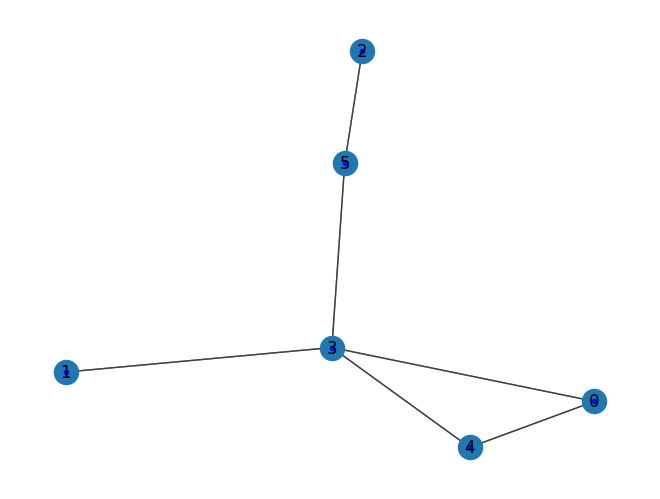

In [12]:
pos = nx.spring_layout(G,seed=42)
nx.draw(G, pos, with_labels = True)
nx.draw_networkx_nodes(G, pos, node_size=10, node_color='b', alpha=0.8)
nx.draw_networkx_edges(G, pos, edge_color='grey', alpha=0.5)
plt.axis('off')
plt.show()

In [14]:
# MIP  model formulation

m = gp.Model("New Transmission placement")

# Add variables
install = m.addVars(edges, vtype=GRB.BINARY, name="Install")
flow = m.addVars(edges, vtype=GRB.CONTINUOUS, name="Flow")

# Add constraints
m.addConstrs((flow.sum(v,'*') - flow.sum('*',v) == supply for v, supply in vertices.items()), name="Flow_conservation") # added constrains so that Energy in = Energy Out
m.addConstrs((flow[e] <= cap[e]*install[e] for e in edges), name="Install2flow") # want to enforce the limits on the maximum current capacity of each cable

# Set objective
m.setObjective(flow.prod(flow_cost) + install.prod(fixed_cost), GRB.MINIMIZE)

m.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 12 rows, 12 columns and 24 nonzeros
Model fingerprint: 0x03b3989f
Variable types: 6 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 6e+00]
Presolve removed 12 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 1: 17 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.700000000000e+01, best bound 1.700000000000e+01, gap 0.0000%


In [18]:
new_cables = {}
for origin, end in install.keys():
  if(abs(install[origin, end].x) > 0.5):
    print(f"Install cable from location {origin } to location {end } in the network ")
    new_cables[(origin, end)] = 0


Install cable from location 0 to location 4 in the network 
Install cable from location 1 to location 3 in the network 
Install cable from location 2 to location 5 in the network 
Install cable from location 3 to location 4 in the network 
Install cable from location 3 to location 5 in the network 


In [19]:
for origin, end in flow.keys():
    if (abs(flow[origin, end].x) > 1e-6):
         print(f"The capacity of cable installed from location {origin } to location {end } is {flow[origin, end].x} MW ")
         if (origin, end) in new_cables:
           new_cables[(origin, end)] = flow[origin, end].x

The capacity of cable installed from location 0 to location 4 is 4.0 MW 
The capacity of cable installed from location 1 to location 3 is 3.0 MW 
The capacity of cable installed from location 2 to location 5 is 2.0 MW 
The capacity of cable installed from location 3 to location 4 is 2.0 MW 
The capacity of cable installed from location 3 to location 5 is 1.0 MW 


In [22]:
G_new = nx.Graph()
for edg in new_cables:
    G_new.add_edge(edg[0], edg[1], weight=new_cables[edg])

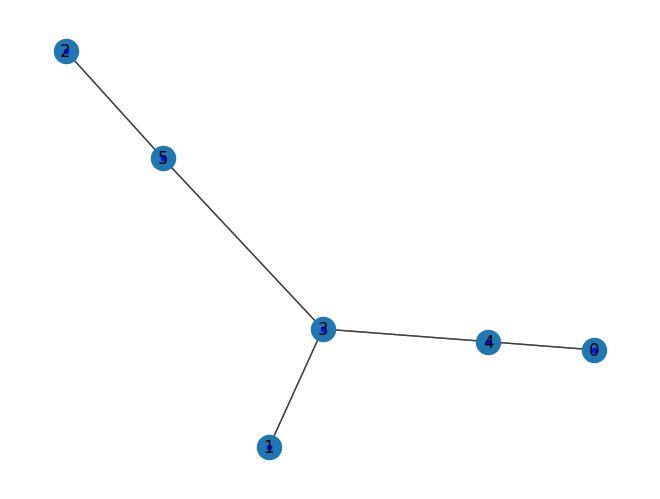

In [23]:
pos = nx.spring_layout(G_new,seed=42)
nx.draw(G_new, pos, with_labels = True)
nx.draw_networkx_nodes(G_new, pos, node_size=10, node_color='b', alpha=0.8)
nx.draw_networkx_edges(G_new, pos, edge_color='grey', alpha=0.5)
plt.axis('off')
plt.show()

 Note: Edge between 0 and 3 has been removed